In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

In [2]:
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

# Метрики качества

Поговорим о бинарной классификации (потому что ею будем пользоваться дальше) и о необычных метриках.

* Метрики - то, за что вам платят
* Оптимизируемый функционал - то, как вы оптимизируете метрики

## Бинарная классификация

![](https://keytodatascience.com/wp-content/uploads/2019/09/binary-classification.jpg)

Большинство стандартных метрик бинарной классификации основано на этой матрице. 

$$
	Accuracy = \frac{TP + TN}{TP + FP + FN + TN}
$$
	

* Доля правильных ответов классификатора
* Самый простой способ оценить качество классификации
* Плохо работает, если классы несбалансированы

$$
Precision = \frac{TP}{TP + FP}
$$

* Precision (точность) - какая доля объектов, выделенных классификатором как положительные, действительно является положительной (при этом не важно, сколько мы классифицировали)
* Ей важно, чтобы из всех, которые мы назвали положительными, было много по-настоящему положительных

$$
Recall = \frac{TP}{TP + FN}
$$

* Recall (полнота) - какая часть положительных объектов была выделена классификатором
* Ей важно, чтобы для наибольшего количества положительных мы сказали, что они положительные, не очень важно, что говорим на остальных объектах

А вообще, это далеко не всё...

![](https://i.ibb.co/xf1BWVN/Screenshot-from-2020-05-02-15-08-18.png)

Сгенерируем небольшую простую выборку для задачи бинарной классификации и обучим логистическую регрессию:

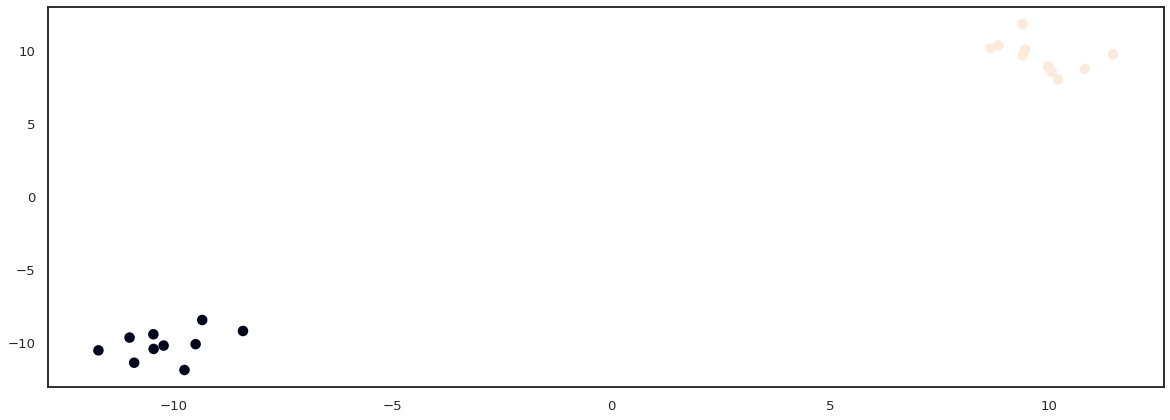

In [3]:
X, y = make_blobs(n_samples=20, centers=[(-10, -10), (10, 10)], n_features=2, random_state=42)

a = plt.scatter(X[:, 0], X[:, 1], c=y)

lr = LogisticRegression(solver='liblinear', random_state=42).fit(X, y)

**Задание 1**. Сгенерируйте тестовые выборки, содержащию не менее 10 различных объектов с ответами, так, чтобы для обученного классификатора, применённого на ней:
* *(0.5 балла)* `Positive likelihood ratio` был равен 0
* *(0.5 балла)* `Positive likelihood ratio` был равен 1

Объясните, почему вы сгенерировали именно такие выборки.

In [4]:
### YOUR CODE HERE ###

YOUR ANSWER HERE

## Необычные метрики

Чаще в жизни встречаются более сложные задачи, чем бинарная классификация. Например, задача машинного перевода. Как оценивать его качество - менее понятно. Даже, скажем прямо, вообще непонятно...

Но люди не сидели на месте и придумали, например, [`BLEU`](https://en.wikipedia.org/wiki/BLEU). Он основан на униграммах, биграммах, триграммах и 4-граммах. Алгоритм примерно такой:
* Найдём все нужные $n$-граммы размеров от 1 до 4
* Посчитаем precision для $n$-грамм разера от 1 до 4
* Возведём в экспоненту среднее от логарифма precision'ов
* Умножим на brevity penalty: штраф за слишком короткие предложения

$$
BLEU = BP * \exp\left(\sum\limits_{i=1}^n w_n \log (p_n)\right)
$$
$$
BP = \begin{cases}
1, c \geqslant r\\
exp(1 - r/c), c < r
\end{cases}
$$
где $c$ - длина перевода, $r$ - длина настоящего предложения

Рассмотрим на примере. Пусть есть настоящий перевод гласит "The cat is sitting on the mat". И есть два перевода:
* On the mat is a cat 
* There is cat sitting cat

Найдём precision'ы для первого:

![](https://miro.medium.com/max/1400/1*WSYhIsrWwRcdReNiGQ7Z2Q.png)

Если нет ни одной 4-граммы, то BLEU равен 0. Чтобы всё же оценить разницу, посчитаем BLEU3, где не используются 4-граммы:

In [5]:
from nltk.translate.bleu_score import sentence_bleu

reference = [['the', 'cat', 'is', 'sitting', 'on', 'the', 'mat']]
candidate1 = ['on','the', 'mat', 'is', 'a', 'cat']
candidate2 = ['there', 'is', 'cat', 'sitting', 'on', 'the', 'cat']

score1 = sentence_bleu(reference, candidate1, weights=(1/3, 1/3, 1/3))
score2 = sentence_bleu(reference, candidate2, weights=(1/3, 1/3, 1/3))

print('Score for "', ' '.join(candidate1), '" is ', score1)
print('Score for "', ' '.join(candidate2), '" is ', score2)

Score for " on the mat is a cat " is  0.36973494931036327
Score for " there is cat sitting on the cat " is  0.4149132666831218


Ну а вообще то, подходит метрика для задачи и коррелирует ли с реальностью - вопрос очень сложный. По идее, надо для метрик это определять. То есть сделать метрику для метрик...

![](https://i.ibb.co/MCJ0xhL/metrics.jpg)

# Несбалансированные выборки

## Датасет

Сегодня нас будет интересовать [датасет](https://www.kaggle.com/mlg-ulb/creditcardfraud) транзакций кредитных карт, некоторые из которых мошеннические. Можно загрузить [данные](https://yadi.sk/i/f-Q6hy6YUn7drA) напрямую. Посмотрим на них:

In [6]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Shad/2021ml/sem6/'

Mounted at /content/drive


In [7]:
df = pd.read_csv(PATH + 'creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Посмотрим на распределение классов по выборке:

In [8]:
print(df.Class.value_counts())
print ('Class 0 ratio: ', len(df[df.Class == 0]) / len(df))
print ('Class 1 ratio: ', len(df[df.Class == 1]) / len(df))

0    284315
1       492
Name: Class, dtype: int64
Class 0 ratio:  0.9982725143693799
Class 1 ratio:  0.001727485630620034


То есть мошеннических транзакций чуть меньше 0.2% от всех...

## Простая модель

Ладно, будем считать, что мы этого не видели, и обучим какую-нибудь простую модель на максимизацию accuracy:

In [9]:
y = df.Class
X = df.drop('Class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
print('Accuracy score: ', accuracy_score(y_test, dummy_pred))

Accuracy score:  0.9984129659279234


![](https://i.ibb.co/c37mT0m/harold.jpg)

Казалось бы: точность больше 99%, что ещё надо? Но если посмотреть на ответы внимательнее:

In [11]:
print('Unique predicted labels: ', (np.unique(dummy_pred)))

Unique predicted labels:  [0]


Кажется, это не то, чего мы хотим. Всё-таки задача была в том, чтобы **выявлять** мошенников.

## Модели посложнее

### Логистическая регрессия

In [12]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [13]:
print ('Accuracy score: ', accuracy_score(y_test, lr_pred))

Accuracy score:  0.9989607033510295


Получше, чем было, но всё ли в порядке тут со значениями?

In [14]:
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    71117
1       85
Name: 0, dtype: int64

Да, кажется, хоть иногда, но мы всё же говорим, что транзакции мошеннические.

А вообще, если задуматься, то для этой задачи accuracy не очень показательная. Кажется, тут нас интересует в первую очередь recall, чтобы уж точно не допустить мошеннических транзакций. Заодно будем считать и precision с F1.

In [15]:
print ('Recall score: ', recall_score(y_test, lr_pred))
print ('Precision score: ', precision_score(y_test, lr_pred))
print ('F1 score: ', f1_score(y_test, lr_pred))

Recall score:  0.5486725663716814
Precision score:  0.7294117647058823
F1 score:  0.6262626262626262


Кроме этого, полезно смотреть на confusion matrix, которая нам может дать более хорошее представление об ошибках, совершаемых моделью:

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


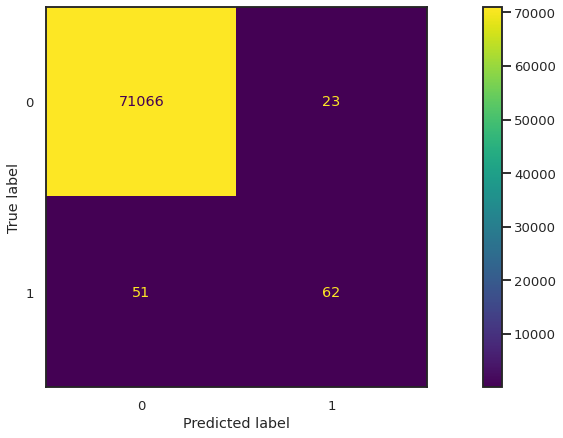

In [16]:
plot_confusion_matrix(lr, X_test, y_test)

### Случайный лес

Говорят, что случайный лес вообще крутой и как-то исходно лучше для несбалансированных выборок, чем другие методы. Проверим:

In [17]:
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [18]:
print ('Accuracy score: ', accuracy_score(y_test, rfc_pred))
print ('Recall score: ', recall_score(y_test, rfc_pred))
print ('Precision score: ', precision_score(y_test, rfc_pred))
print ('F1 score: ', f1_score(y_test, rfc_pred))

Accuracy score:  0.9995646189713772
Recall score:  0.7610619469026548
Precision score:  0.9555555555555556
F1 score:  0.8472906403940886


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


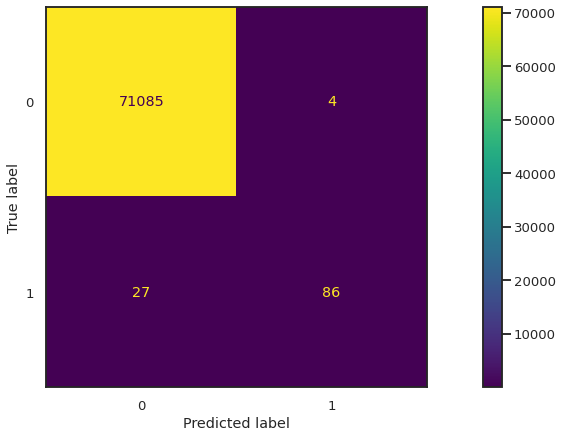

In [19]:
plot_confusion_matrix(rfc, X_test, y_test, values_format='g')

## Методы сэмплирования

Один из методов превращения выборки в сбалансированную - это сэмплирование. По итогу мы хотим, чтобы объектов обоих классов было поровну. Есть два простых метода: undersampling и oversampling. Легче всего пояснить на картинке:

![](https://miro.medium.com/max/725/0*FeIp1t4uEcW5LmSM.png)

Что ж, такие простые методы есть уже готвые: [`sklearn.utils.resample`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html)

**Важный момент**: проводить изменения выборки стоит уже после разделения на обучающую и тестовую. Это нужно, потому что:
* мы хотим тестировать качество на исходных, а не на изменённых данных
* мы не хотим, чтобы в тестовую выборку попали те объекты, которые есть в тренировочной

Чтобы воспользоваться сэмплингом, объединим объекты с ответами обратно и отделим оба класса друг от друга:

In [20]:
X = pd.concat([X_train, y_train], axis=1)
not_fraud = X[X.Class==0]
fraud = X[X.Class==1]

### Oversampling

In [21]:
fraud_oversampled = resample(fraud,
                              replace=True,
                              n_samples=len(not_fraud),
                              random_state=42)

oversampled = pd.concat([not_fraud, fraud_oversampled])

oversampled.Class.value_counts()

1    213226
0    213226
Name: Class, dtype: int64

In [22]:
y_train = oversampled.Class
X_train = oversampled.drop('Class', axis=1)

oversampled_clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

oversampled_pred = oversampled_clf.predict(X_test)

In [23]:
print ('Accuracy score: ', accuracy_score(y_test, oversampled_pred))
print ('Recall score: ', recall_score(y_test, oversampled_pred))
print ('Precision score: ', precision_score(y_test, oversampled_pred))
print ('F1 score: ', f1_score(y_test, oversampled_pred))

Accuracy score:  0.9781747703716188
Recall score:  0.911504424778761
Precision score:  0.06253794778384943
F1 score:  0.11704545454545455


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


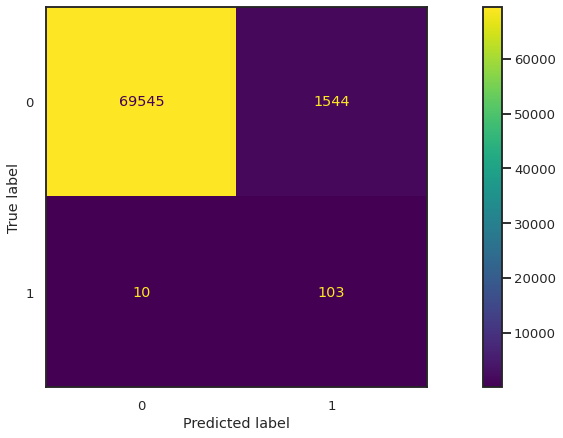

In [24]:
plot_confusion_matrix(oversampled_clf, X_test, y_test, values_format='g')

### Undersampling

In [25]:
not_fraud_undersampled = resample(not_fraud,
                                  replace = False,
                                  n_samples = len(fraud),
                                  random_state = 42)

undersampled = pd.concat([not_fraud_undersampled, fraud])

undersampled.Class.value_counts()

1    379
0    379
Name: Class, dtype: int64

In [26]:
y_train = undersampled.Class
X_train = undersampled.drop('Class', axis=1)

undersampled_clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

undersampled_pred = undersampled_clf.predict(X_test)

In [27]:
print ('Accuracy score: ', accuracy_score(y_test, undersampled_pred))
print ('Recall score: ', recall_score(y_test, undersampled_pred))
print ('Precision score: ', precision_score(y_test, undersampled_pred))
print ('F1 score: ', f1_score(y_test, undersampled_pred))

Accuracy score:  0.9798741608381787
Recall score:  0.9026548672566371
Precision score:  0.06692913385826772
F1 score:  0.12461820403176545


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


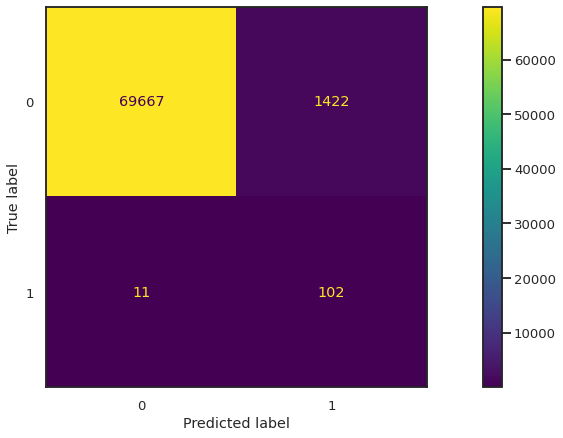

In [28]:
plot_confusion_matrix(undersampled_clf, X_test, y_test, values_format='g')

Главная проблема downsampling'а в том, что мы теряем много данных. А так в целом очень даже и неплохо получается :)

###  Более сложные методы

Более сложные методы - это так или иначе oversampling либо downsampling. Просто не такой обычный, как повторение существующих либо выкидывание данных. Один из них - [`SMOTE`](https://arxiv.org/abs/1106.1813). Его идея такая: давайте для каждого объекта найдём сколько-то ближайших соседей, проведём между ними отрезки и будем генерировать новые точки на этих отрезках. 

<img src="https://miro.medium.com/max/1400/1*6UFpLFl59O9e3e38ffTXJQ.png" alt="drawing" width="600"/>

Для проверки того, что может нам принести этот метод, воспользуемся библиотекой для несбалансированного обучения [`imblearn`](https://imbalanced-learn.readthedocs.io/en/stable/index.html):

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
X = pd.concat([not_fraud, fraud])
print (X.Class.value_counts())

y_train = X.Class
X_train = X.drop('Class', axis=1)

0    213226
1       379
Name: Class, dtype: int64


In [31]:
sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_resample(X_train, y_train)
print (X_train.shape)
print (len(y_train[y_train == 1]))

(426452, 30)
213226


In [32]:
smote_clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote_clf.predict(X_test)

In [33]:
print ('Accuracy score: ', accuracy_score(y_test, smote_pred))
print ('Recall score: ', recall_score(y_test, smote_pred))
print ('Precision score: ', precision_score(y_test, smote_pred))
print ('F1 score: ', f1_score(y_test, smote_pred))

Accuracy score:  0.9850285104351001
Recall score:  0.8849557522123894
Precision score:  0.08673026886383348
F1 score:  0.15797788309636648


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


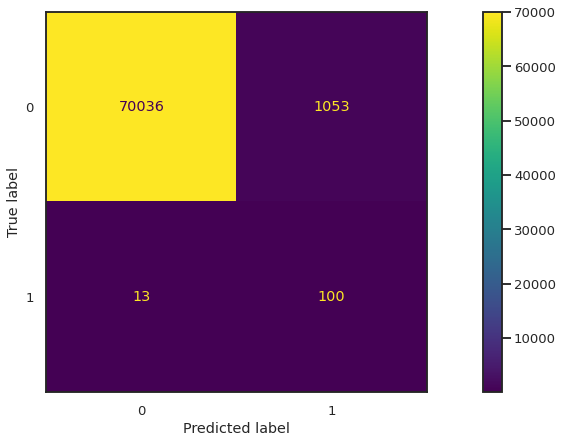

In [34]:
plot_confusion_matrix(smote_clf, X_test, y_test, values_format='g')

**Задание 2** *(1 балл)*. Давайте попробуем реализовать подобие SMOTE своими руками. Для этого:
* для каждого объекта из меньшего класса найдите ближайшего соседа
* для генерации объекта между ними используйте линейную интерполяцию и равномерное распределение веса
* при генерации очередного синтетического объекта выбирайте реальный объект равномерно случайным образом
* проделайте oversampling, запустите на нём линейную регрессию, получите результаты метрик и сделайте выводы о том, хорош такой метод или нет и почему

In [35]:
### YOUR CODE HERE ###

YOUR ANSWER HERE

## Реальная жизнь

Представьте себе ситуацию: вы банк и за каждую транзакцию вы получаете комиссию в виде 10% от суммы транзакции. Если же транзакция оказалась мошеннической, то вы эту комиссию выплачиваете клиенту в качестве компенсации. За отменённую по вашей инициативе транзакцию вы комиссию не получаете. Очевидно, что в данной ситуации ни одна из метрик, которые мы обсуждали в этом разделе, не подойдёт.

Но вы же работаете в банке и хотите много денег!

<img src="https://avatars.mds.yandex.net/get-zen_doc/237236/pub_5d91b1151febd400b0563c15_5d91b1e7e6cb9b00ad469bde/scale_1200" alt="drawing" width="900"/>

**Задание 3**
* *(0.5 балла)* Реализуйте метрику, показывающую, сколько денег вы заработаете на тестовом датасете. Примените её к тем моделям, которые мы обучали и посмотрите, какая ведёт себя лучше. Сделайте выводы, а также поразмышляйте на тему того, как связаны эта метрика с accuracy, reacall, precision и F1.
* *(0.5 балла)* Придумайте способ сэмплирования (не важно, over или down), который поможет логистической регрессии без дополнительной настройки параметров улучшить значение метрики. Даже если не получится улучшить, аргументируйте, почему такой метод показался вам разумным и должен был сработать.

In [36]:
### YOUR CODE HERE ###

YOUR ANSWER HERE